In [ ]:
# pip install onnxruntime
# !pip install onnxruntime-gpu

# **Import Necessary Libraries**

In [ ]:
import os
import torch
import warnings
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import torch.nn as nn
from tqdm import tqdm
import onnxruntime as ort
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import GradScaler, autocast
from torchvision.transforms import v2 as transforms
from sklearn.metrics import precision_recall_fscore_support
warnings.filterwarnings('ignore')

In [90]:
# to encode the column names after reading the dataset
col_name_encoding={0: 'No_Dr', 1: 'Mild', 2: 'Moderate', 3: 'severe', 4: 'Proliferative DR'}
# base dataset path in kaggle directory
dataset_base_path='/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data'

# **Total Files in Training Data**

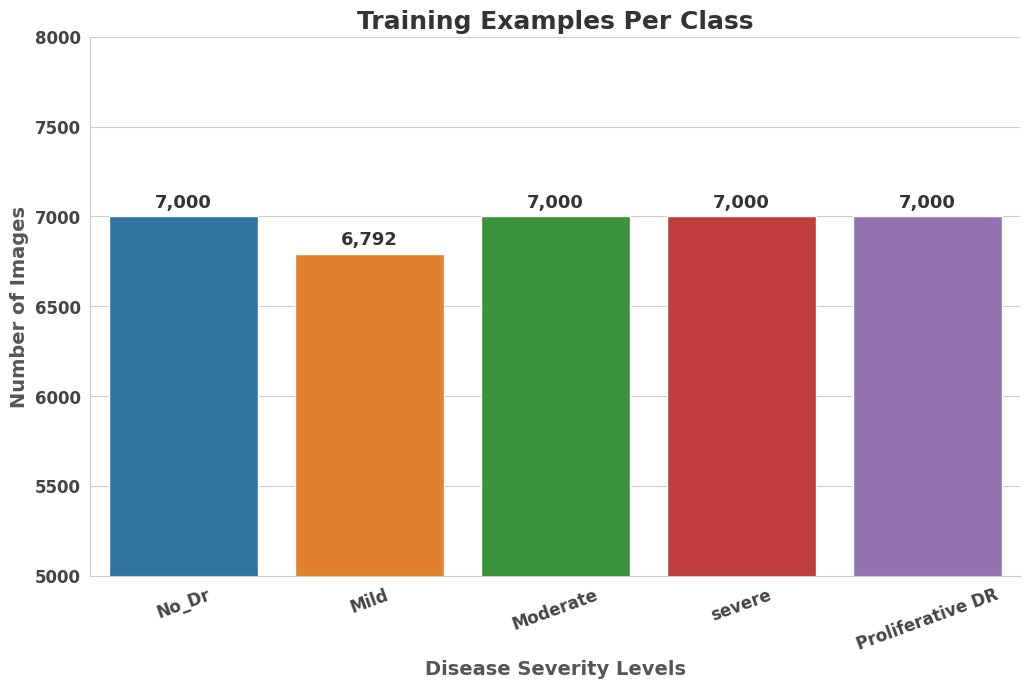

In [91]:
train_path = dataset_base_path + '/train'

class_names = sorted(os.listdir(train_path))  # Ensure sorting matches encoding
training_examples = [len(os.listdir(os.path.join(train_path, class_name))) for class_name in class_names]

class_labels = [col_name_encoding[int(cls)] for cls in class_names]


sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))
colors = sns.color_palette()
ax = sns.barplot(x=class_labels, y=training_examples, palette=colors)

plt.ylim(5000, max(training_examples) + 1000)

for i, count in enumerate(training_examples):
    ax.text(i, count + 50, f"{count:,}", ha='center', fontsize=13, fontweight='bold', color='#333')

plt.title("Training Examples Per Class", fontsize=18, fontweight='bold', color='#333')
plt.xlabel("Disease Severity Levels", fontsize=14, fontweight='bold', color='#555')
plt.ylabel("Number of Images", fontsize=14, fontweight='bold', color='#555')
plt.xticks(rotation=20, fontsize=12, fontweight='bold', color='#444')
plt.yticks(fontsize=12, fontweight='bold', color='#444')
sns.despine()

plt.show()

# **Total Files in Validation Data**

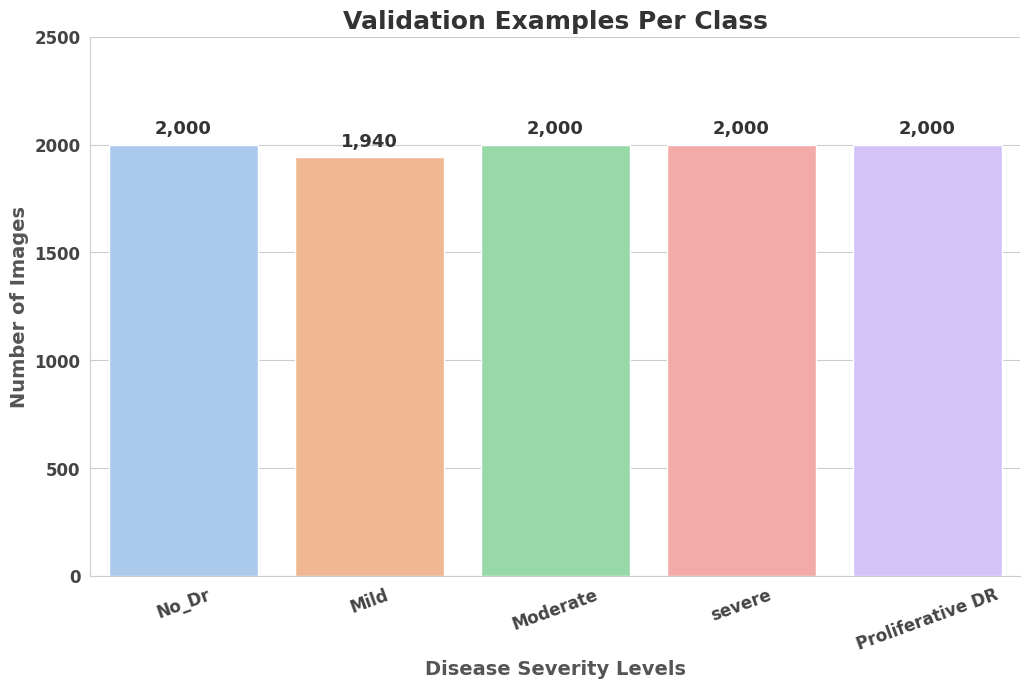

In [92]:
validation_path = dataset_base_path + '/val'

class_names = sorted(os.listdir(validation_path))  # Ensure sorting matches encoding
validation_examples = [len(os.listdir(os.path.join(validation_path, class_name))) for class_name in class_names]
class_labels = [col_name_encoding[int(cls)] for cls in class_names]

sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))
colors = sns.color_palette("pastel")
ax = sns.barplot(x=class_labels, y=validation_examples, palette=colors)

plt.ylim(0, max(validation_examples) +500)

for i, count in enumerate(validation_examples):
    ax.text(i, count + 50, f"{count:,}", ha='center', fontsize=13, fontweight='bold', color='#333')

plt.title("Validation Examples Per Class", fontsize=18, fontweight='bold', color='#333')
plt.xlabel("Disease Severity Levels", fontsize=14, fontweight='bold', color='#555')
plt.ylabel("Number of Images", fontsize=14, fontweight='bold', color='#555')
plt.xticks(rotation=20, fontsize=12, fontweight='bold', color='#444')
plt.yticks(fontsize=12, fontweight='bold', color='#444')
sns.despine()

plt.show()

# **Total Files in Testing Data**

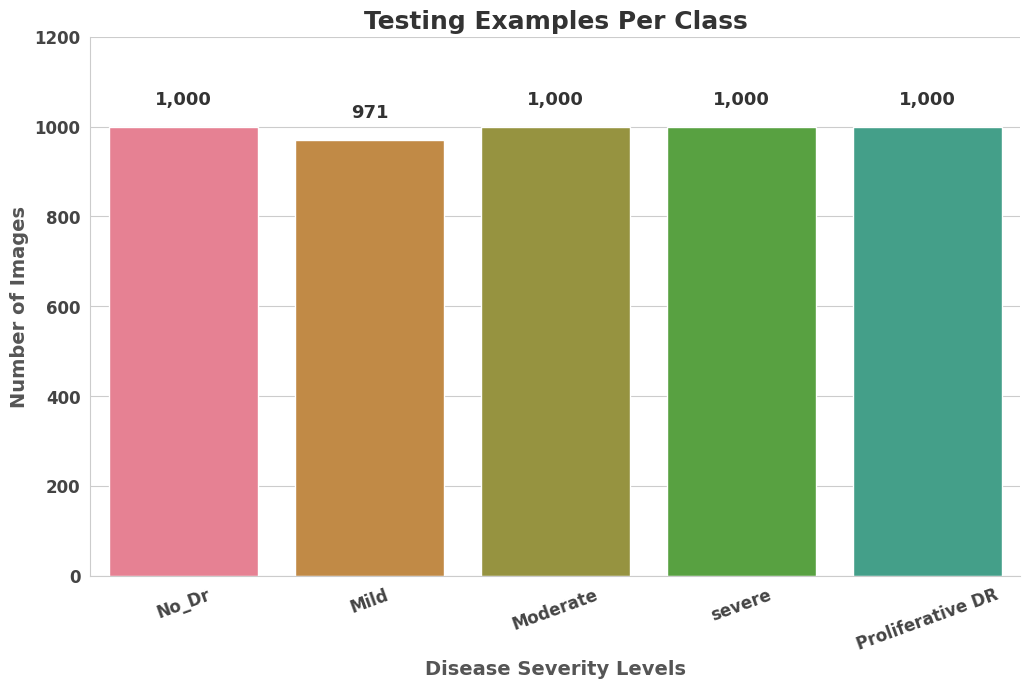

In [93]:
test_path = dataset_base_path + '/test'

class_names = sorted(os.listdir(test_path))  # Ensure sorting matches encoding
testing_examples = [len(os.listdir(os.path.join(test_path, class_name))) for class_name in class_names]
class_labels = [col_name_encoding[int(cls)] for cls in class_names]

sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))
colors = sns.color_palette("husl", 9)
ax = sns.barplot(x=class_labels, y=testing_examples, palette=colors)

plt.ylim(0, max(testing_examples) +200)

for i, count in enumerate(testing_examples):
    ax.text(i, count + 50, f"{count:,}", ha='center', fontsize=13, fontweight='bold', color='#333')

plt.title("Testing Examples Per Class", fontsize=18, fontweight='bold', color='#333')
plt.xlabel("Disease Severity Levels", fontsize=14, fontweight='bold', color='#555')
plt.ylabel("Number of Images", fontsize=14, fontweight='bold', color='#555')
plt.xticks(rotation=20, fontsize=12, fontweight='bold', color='#444')
plt.yticks(fontsize=12, fontweight='bold', color='#444')
sns.despine()

plt.show()

# **Finding Original Files and Ignoring the Augmented Files**

In [94]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Function to check original files and sort in descending order
def check_original_files(base_path, folder_name):
    train_path = os.path.join(base_path, folder_name)
    class_folders = sorted(os.listdir(train_path))
    
    image_counts = []
    labels = []
    
    for folder in class_folders:
        folder_path = os.path.join(train_path, folder)
        temp = os.listdir(folder_path)
        image_paths = list(filter(lambda path: "aug" not in path, temp))
        
        image_counts.append(len(image_paths))
        labels.append(col_name_encoding[int(folder)])  # Assign class names

    # Sort data in descending order
    sorted_indices = sorted(range(len(image_counts)), key=lambda i: image_counts[i], reverse=True)
    sorted_counts = [image_counts[i] for i in sorted_indices]
    sorted_labels = [labels[i] for i in sorted_indices]

    return sorted_labels, sorted_counts

# Function to plot bar graphs
def plot_bar_graph(labels, counts, title, color_palette):
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette(color_palette, len(labels))  # Assign color palette
    bars = plt.bar(labels, counts, color=colors)

    # Add exact count on top of bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count), 
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Styling
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel("Class", fontsize=14, fontweight='bold')
    plt.ylabel("Count", fontsize=14, fontweight='bold')
    plt.xticks(rotation=20, fontsize=12, fontweight='bold', color='#444')
    plt.yticks(fontsize=12, fontweight='bold', color='#444')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()

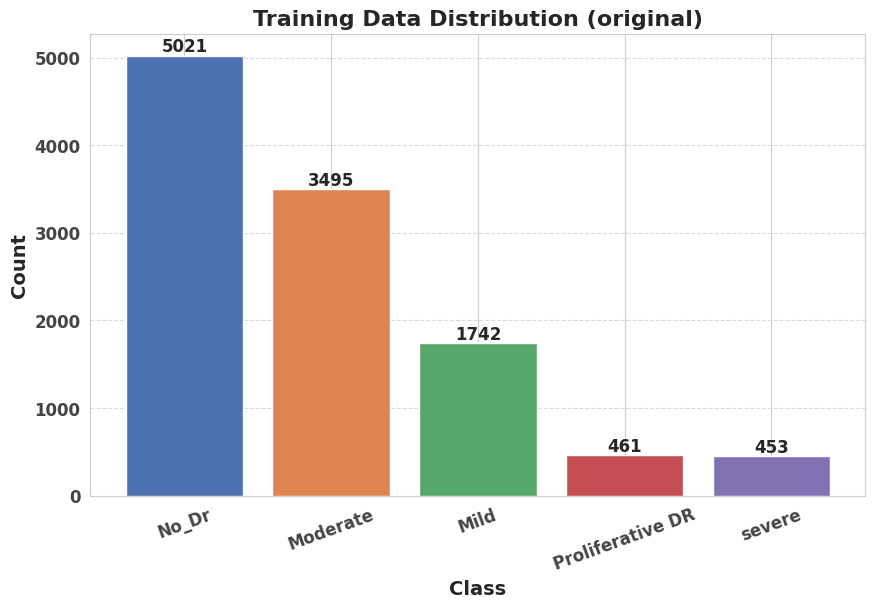

In [95]:
train_labels, train_counts = check_original_files(dataset_base_path, 'train')
plot_bar_graph(train_labels, train_counts, "Training Data Distribution (original)", "deep")  

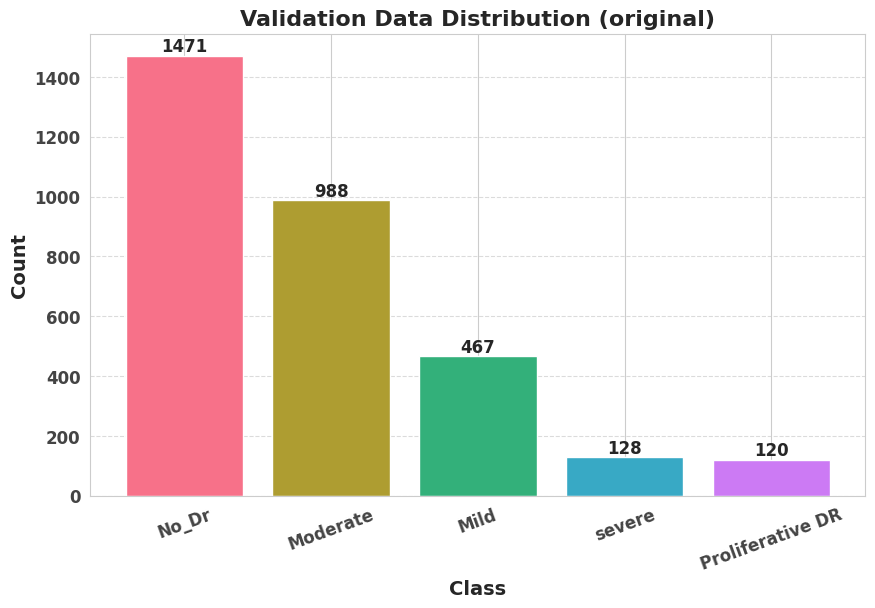

In [96]:
val_labels, val_counts = check_original_files(dataset_base_path, 'val')
plot_bar_graph(val_labels, val_counts, "Validation Data Distribution (original)", "husl")  

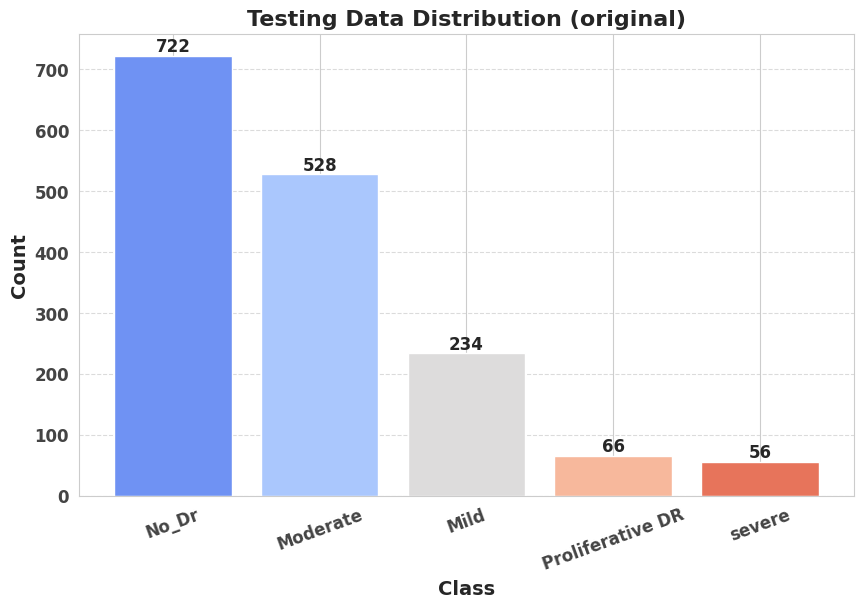

In [97]:
test_labels, test_counts = check_original_files(dataset_base_path, 'test')
plot_bar_graph(test_labels, test_counts, "Testing Data Distribution (original)", "coolwarm")  

# **Checking how the Images Look Like in the Training Dataset**

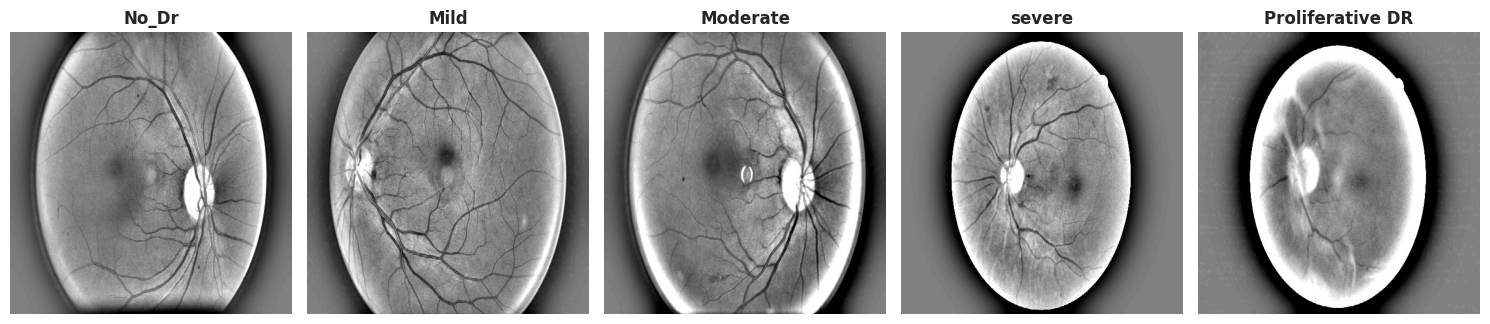

In [98]:
import os
import matplotlib.pyplot as plt
import cv2 

train_path = os.path.join(dataset_base_path, 'train')
class_folders = sorted(os.listdir(train_path))

image_paths = []
for folder in class_folders:
    folder_path = os.path.join(train_path, folder)
    temp=os.listdir(folder_path)
    temper = list(filter(lambda path: "aug" not in path, temp))
    if temper: 
        image_paths.append(os.path.join(folder_path, temper[0]))  # Pick the first sorted image

plt.figure(figsize=(15, 5))  

for i, img_path in enumerate(image_paths):
    img = cv2.imread(img_path)  # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.subplot(1, len(image_paths), i + 1)  # Row=1, Column=total_classes
    plt.imshow(img)
    plt.axis("off")  # Hide axes
    plt.title(f"{col_name_encoding[i]}", fontsize=12, fontweight='bold')  # Add titles

plt.tight_layout()
plt.show()


# **Custom DataFrame Function**

In [99]:
def create_dataframe(base_path,folder_name):
    folder_path=base_path+'/'+folder_name
    hold=os.listdir(folder_path)
    image_paths=[]
    image_labels=[]
    for i in hold:
        labels=[i]*len(os.listdir(folder_path+'/'+i))
        path=[folder_path+'/'+i+'/'+tt for tt in os.listdir(folder_path+'/'+i)]
        image_paths.extend(path)
        image_labels.extend(labels)
    
    DATASET=pd.DataFrame({'File_Paths':image_paths,'Labels':image_labels})
    return DATASET

In [100]:
TRAIN_DATASET=create_dataframe(dataset_base_path,'train')
TRAIN_DATASET.head()

,File_Paths,Labels
0,/kaggle/input/diabetic-retinopathy-balanced/co...,2
1,/kaggle/input/diabetic-retinopathy-balanced/co...,2
2,/kaggle/input/diabetic-retinopathy-balanced/co...,2
3,/kaggle/input/diabetic-retinopathy-balanced/co...,2
4,/kaggle/input/diabetic-retinopathy-balanced/co...,2


In [101]:
VAL_DATASET=create_dataframe(dataset_base_path,'val')
VAL_DATASET.head()

,File_Paths,Labels
0,/kaggle/input/diabetic-retinopathy-balanced/co...,2
1,/kaggle/input/diabetic-retinopathy-balanced/co...,2
2,/kaggle/input/diabetic-retinopathy-balanced/co...,2
3,/kaggle/input/diabetic-retinopathy-balanced/co...,2
4,/kaggle/input/diabetic-retinopathy-balanced/co...,2


In [102]:
TEST_DATASET=create_dataframe(dataset_base_path,'test')
TEST_DATASET.head()

,File_Paths,Labels
0,/kaggle/input/diabetic-retinopathy-balanced/co...,2
1,/kaggle/input/diabetic-retinopathy-balanced/co...,2
2,/kaggle/input/diabetic-retinopathy-balanced/co...,2
3,/kaggle/input/diabetic-retinopathy-balanced/co...,2
4,/kaggle/input/diabetic-retinopathy-balanced/co...,2


# **Custom Dataset Class to prepare the Dataset**

In [103]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),  # Ensure all images are (512,512)
            transforms.ToTensor(),  # Convert to tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]["File_Paths"]
        label = self.dataframe.iloc[idx]["Labels"]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        label = torch.tensor(int(label), dtype=torch.long)
        return image, label

# **Makiing Training, Testing and Validation Loaders**

In [104]:
train_dataset = CustomDataset(TRAIN_DATASET)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset=CustomDataset(VAL_DATASET)
val_loader=DataLoader(val_dataset, batch_size=16, shuffle=False)

test_dataset=CustomDataset(TEST_DATASET)
test_loader=DataLoader(test_dataset, batch_size=16, shuffle=False)

# **Pre-Trained Model = efficientnet_b4**
## **I included New Dense Layers to adopt to the Dataset classes**

In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EfficientNet-B4 Pretrained Model
model = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1)
# Add My own Custom Neural Network
model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 5)  # 5 classes
)
model = model.to(device)

In [106]:
# Define Loss, Optimizer, and Scheduler and Mixed Precision Training
scaler = GradScaler()  
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


# Early Stopping & Model Checkpointing
patience = 2
early_stopping_counter = 0
best_val_loss = float("inf")
checkpoint_path = "efficientnet_b4_best.pth"

# **Training and Validation Loop**

In [28]:
# Training Loop
num_epochs = 20
validation_loss=[]
training_loss=[]
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        with autocast():  # Mixed Precision
            outputs = model(images)
            loss = loss_fn(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        pbar.set_postfix(loss=running_loss / len(train_loader))

    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}")
    training_loss.append(running_loss / len(train_loader))

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total * 100
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
    validation_loss.append(avg_val_loss)

    # Early Stopping & Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), checkpoint_path)
        print("🔥 Model saved!")

        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("🚨 Early Stopping Triggered! Stopping Training.")
            break

print("✅ Training Complete! Best model saved as:", checkpoint_path)


# **Graph for Training and Validation Losses**

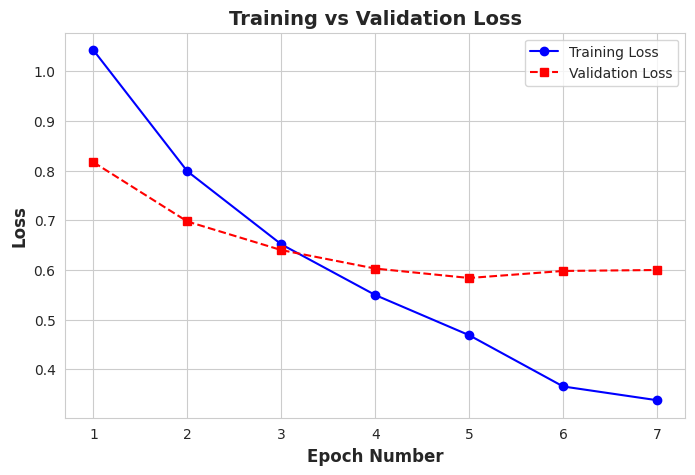

In [107]:
# i didnt saved the loss values initially so had to resort to manual work but re-running the training code will automatically log the losses
# # Loss values
# training_loss = [1.0425, 0.7985, 0.6515, 0.5494, 0.4684, 0.3652, 0.3375]
# validation_loss = [0.8168, 0.6975, 0.6399, 0.6027, 0.5837, 0.5979, 0.5998]

# Epoch numbers
epochs = list(range(1, len(training_loss) + 1))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, training_loss, marker='o', linestyle='-', label='Training Loss', color='blue')
plt.plot(epochs, validation_loss, marker='s', linestyle='--', label='Validation Loss', color='red')

# Labels and Title
plt.xlabel("Epoch Number", fontsize=12, fontweight="bold")
plt.ylabel("Loss", fontsize=12, fontweight="bold")
plt.title("Training vs Validation Loss", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True)

# Show plot
plt.show()


# **Putting the Model to the Test**

In [141]:
# Load Pretrained EfficientNet-B4 Model
model = models.efficientnet_b4(weights=None)  # Load architecture
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 5)  # 5 classes
)
model = model.to(device)

# Loading fine-tuned Model
try:
    model.load_state_dict(torch.load("/kaggle/input/efficient_model_b4/pytorch/default/1/efficientnet_b4_best.pth"))
    model.eval()  # Set model to evaluation mode
    print("✅ Model loaded successfully!")
except Exception as e:
    print("❌ Model loading not successful. Error:", str(e))

✅ Model loaded successfully!


In [53]:
# ✅ Testing Phase
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# ✅ Compute Metrics
avg_test_loss = test_loss / len(test_loader)
test_acc = correct / total * 100
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="macro"
)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="weighted"
)

# ✅ Print Results
print(f"📉 TESTING LOSS: {avg_test_loss:.4f}")
print(f"✅ TESTING ACCURACY: {test_acc:.2f}%")
print(f"\n🔹 Precision (Macro): {precision_macro:.4f} \n🔹 Recall    (Macro): {recall_macro:.4f} \n🔹 F1-Score  (Macro): {f1_macro:.4f}")
print(f"\n🔸 Precision (Weighted): {precision_weighted:.4f} \n🔸 Recall    (Weighted): {recall_weighted:.4f} \n🔸 F1-Score  (Weighted): {f1_weighted:.4f}")


📉 TESTING LOSS: 0.5921
✅ TESTING ACCURACY: 75.58%

🔹 Precision (Macro): 0.7575 
🔹 Recall    (Macro): 0.7549 
🔹 F1-Score  (Macro): 0.7546

🔸 Precision (Weighted): 0.7581 
🔸 Recall    (Weighted): 0.7558 
🔸 F1-Score  (Weighted): 0.7554


# **Model Optimization**

### **First we will check inferrence speed of fine-tuned model on GPU (Tesla T4 15 GB)**

In [109]:
import time
import torch

# Get one batch from test_loader
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
model.to(device)
# Measure inference time
with torch.no_grad():
    start_time = time.time()  # Start timer
    outputs = model(images)   # Forward pass
    end_time = time.time()    # End timer

# Calculate elapsed time
inference_time = end_time - start_time
print(f"Inference Time for 1 Batch (16 images) : {inference_time:.6f} seconds")

Inference Time for 1 Batch (16 images) : 0.018983 seconds


### **Now we will check inferrence speed of fine-tuned model on CPU**

In [110]:
# Get one batch from test_loader
images, labels = next(iter(test_loader))
model.to('cpu')
# Measure inference time
with torch.no_grad():
    start_time = time.time()  # Start timer
    outputs = model(images)   # Forward pass
    end_time = time.time()    # End timer

# Calculate elapsed time
inference_time = end_time - start_time
print(f"Inference Time for 1 Batch (16 images): {inference_time:.6f} seconds")

Inference Time for 1 Batch (16 images): 11.639185 seconds


## **Now, in order to increase the inferrence speed. I will perform some optimizations while i try to keep the accuracy almost the same**
### **Cannot Use Quantization Because of the following reason**
*  EfficientNet are not compatible with dynamic quantization.
*  EfficientNet heavily uses **depthwise convolutions**, **batch normalization**, and **squeeze-excitation blocks**, which are not supported by torch.quantization.quantize_dynamic()

## **Optimized Model Testing Accuracy**


In [111]:
scripted_model = torch.jit.script(model)
scripted_model.save("efficientnet_b4_scripted.pth")
print("Model scripted successfully!")

Model scripted successfully!


In [68]:
# ✅ Testing Phase
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_preds = []
scripted_model.to(device)
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)

        outputs = scripted_model(images)
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# ✅ Compute Metrics
avg_test_loss = test_loss / len(test_loader)
test_acc = correct / total * 100
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="macro"
)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="weighted"
)

# ✅ Print Results
print(f"📉 TESTING LOSS: {avg_test_loss:.4f}")
print(f"✅ TESTING ACCURACY: {test_acc:.2f}%")
print(f"\n🔹 Precision (Macro): {precision_macro:.4f} \n🔹 Recall    (Macro): {recall_macro:.4f} \n🔹 F1-Score  (Macro): {f1_macro:.4f}")
print(f"\n🔸 Precision (Weighted): {precision_weighted:.4f} \n🔸 Recall    (Weighted): {recall_weighted:.4f} \n🔸 F1-Score  (Weighted): {f1_weighted:.4f}")


Testing: 100%|██████████| 311/311 [01:57<00:00,  2.65it/s]

📉 TESTING LOSS: 0.5921
✅ TESTING ACCURACY: 75.58%

🔹 Precision (Macro): 0.7575 
🔹 Recall    (Macro): 0.7549 
🔹 F1-Score  (Macro): 0.7546

🔸 Precision (Weighted): 0.7581 
🔸 Recall    (Weighted): 0.7558 
🔸 F1-Score  (Weighted): 0.7554


### **Inferrence speed of Optimized model on GPU (Tesla T4 15 GB)**

In [114]:
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
scripted_model.to(device)
with torch.no_grad():
    start_time = time.time()
    outputs = scripted_model(images)
    end_time = time.time()

inference_time = end_time - start_time

print(f"Inference Time on 1 : {inference_time:.6f} seconds")

Inference Time on 1 : 0.010178 seconds


### **Inferrence Speed of Optimized Model on CPU**

In [117]:
images, labels = next(iter(test_loader))
scripted_model.to('cpu')
# Measure inference time
with torch.no_grad():
    start_time = time.time() 
    outputs = scripted_model(images)   
    end_time = time.time()    

# Calculate elapsed time
inference_time = end_time - start_time
print(f"Inference Time for 1 Batch (16 images): {inference_time:.6f} seconds")

Inference Time for 1 Batch (16 images): 11.644101 seconds


## **Converting the Model to ONNX Format**

In [121]:
import torch
onnx_model=models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1)
# Add My own Custom Neural Network
onnx_model.classifier[1] = nn.Sequential(
    nn.Linear(onnx_model.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 5)  # 5 classes
)
# Load the model
try:
    onnx_model.load_state_dict(torch.load("/kaggle/input/efficient_model_b4/pytorch/default/1/efficientnet_b4_best.pth", map_location="cpu"))
    onnx_model.eval()  # Set model to evaluation mode
    print("Model loaded successfully!")
except Exception as e:
    print("Model loading not successful:", str(e))

# Define dummy input matching the input shape of your model
dummy_input = torch.randn(1, 3, 512, 512) 

# Export the model to ONNX format
onnx_model_path = "efficientnet_b4_best.onnx"
torch.onnx.export(
    onnx_model, 
    dummy_input, 
    onnx_model_path, 
    input_names=["input"], 
    output_names=["output"], 
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
)

print(f"Model successfully converted to ONNX format and saved as {onnx_model_path}")


Model loaded successfully!
Model successfully converted to ONNX format and saved as efficientnet_b4_best.onnx


## **Testing the ONNX Format Model's Testing Accuracy**

In [132]:
onnx_model_path = "/kaggle/working/efficientnet_b4_best.onnx"
ort_session = ort.InferenceSession(onnx_model_path, providers=["CUDAExecutionProvider"])

test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images_np = images.cpu().numpy()
        labels_np = labels.cpu().numpy()

        ort_inputs = {ort_session.get_inputs()[0].name: images_np}
        ort_outputs = ort_session.run(None, ort_inputs)
        outputs = torch.tensor(ort_outputs[0])  # Convert ONNX output back to PyTorch tensor

        loss = loss_fn(outputs, torch.tensor(labels_np))  
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted.numpy() == labels_np).sum().item()
        total += labels_np.shape[0]

        all_labels.extend(labels_np)
        all_preds.extend(predicted.numpy())

# ✅ Compute Metrics
avg_test_loss = test_loss / len(test_loader)
test_acc = correct / total * 100
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="macro"
)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="weighted"
)

# ✅ Print Results
print(f"📉 TESTING LOSS: {avg_test_loss:.4f}")
print(f"✅ TESTING ACCURACY: {test_acc:.2f}%")
print(f"\n🔹 Precision (Macro): {precision_macro:.4f} \n🔹 Recall    (Macro): {recall_macro:.4f} \n🔹 F1-Score  (Macro): {f1_macro:.4f}")
print(f"\n🔸 Precision (Weighted): {precision_weighted:.4f} \n🔸 Recall    (Weighted): {recall_weighted:.4f} \n🔸 F1-Score  (Weighted): {f1_weighted:.4f}")


Testing: 100%|██████████| 311/311 [01:58<00:00,  2.62it/s]

📉 TESTING LOSS: 0.5921
✅ TESTING ACCURACY: 75.58%

🔹 Precision (Macro): 0.7575 
🔹 Recall    (Macro): 0.7549 
🔹 F1-Score  (Macro): 0.7546

🔸 Precision (Weighted): 0.7581 
🔸 Recall    (Weighted): 0.7558 
🔸 F1-Score  (Weighted): 0.7554


### **Inferrence Speed of ONNX format Model on GPU**

In [129]:
# Load ONNX model with GPU execution
onnx_model_path = "/kaggle/working/efficientnet_b4_best.onnx"

ort_session = ort.InferenceSession(onnx_model_path, providers=["CUDAExecutionProvider"])

# Run inference on one batch
test_loader_iter = iter(test_loader)
images, labels = next(test_loader_iter)  # Get one batch
images = images.numpy()  # Convert PyTorch tensor to NumPy array

# Measure inference time
import time
start_time = time.time()

# Perform inference
outputs = ort_session.run(None, {"input": images})

end_time = time.time()
print(f"Inference time on GPU: {end_time - start_time:.6f} seconds")

Inference time on GPU: 0.454485 seconds


### **Inferrence Speed of ONNX format Model on CPU**

In [127]:
# Load ONNX model
onnx_model_path = "/kaggle/working/efficientnet_b4_best.onnx"
session = ort.InferenceSession(onnx_model_path, providers=["CPUExecutionProvider"])

# Get input and output names
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Get one batch from the test loader
images, labels = next(iter(test_loader))
images = images.numpy()  # Convert to NumPy for ONNX inference

# Measure inference time
start_time = time.time()
outputs = session.run([output_name], {input_name: images})
end_time = time.time()

# Compute inference time
inference_time = end_time - start_time
print(f"Inference Time for 1 batch: {inference_time:.6f} seconds")


Inference Time for 1 batch: 4.695091 seconds


# **The End**
### **Core Details are documented in the report file**